In [1]:
%matplotlib widget
import torch
import os
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli

In [2]:
configurationFile = './configurations/01_tgv.toml'

with open(configurationFile, 'r') as f:
    config = f.read()

config = tomli.loads(config)

In [3]:
# config

In [4]:
nx = 128
L = 1
u_mag = 2
k = 1 * np.pi
TGV_override = False
targetRe = 2000

config['domain']['minExtent'] = -L
config['domain']['maxExtent'] =  L

config['particle'] = {'nx' : nx}
config['fluid'] = {'cs' : u_mag * 10}
config['compute'] = {'device': 'cuda'}
config['plot']['export'] = True
config['kernel'] = {'name': 'Wendland4'}
# config['kernel']['targetNeighbors'] = 100
# config['compute'] = {'device': 'cpu'}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)
setViscosityParameters(config, targetRe, L, u_mag)
config['integration']['scheme'] = 'symplecticEuler'

print(rf'Re = {config["diffusion"]["Re"]}, $\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$, $\alpha = {config["diffusion"]["alpha"]}$')


$\alpha = 0.00943240337073803$ is very low, consider increasing the value (should be > 0.01)
Re = 1999.9996337890625, $\nu_{sph} = 0.0020000003278255463$, $\alpha = 0.00943240337073803$


In [5]:
# def sampleNoisyParticles(noiseConfig, config, sdfs = [], randomizeParticles = False):
#     particlesA, volumeA = sampleRegular(config['particle']['dx'], config['domain']['dim'], config['domain']['minExtent'], config['domain']['maxExtent'], config['kernel']['targetNeighbors'], config['simulation']['correctArea'], config['kernel']['function'])
#     particlesA = particlesA.to(config['compute']['device'])
#     volumeA = volumeA.to(config['compute']['device'])
    
#     area = (4 / config['particle']['nx']**2)
#     area = volumeA
#     grid, noiseSimplex = sampleNoise(noiseConfig)

#     noiseState = {}
#     noiseState['numParticles'] = particlesA.shape[0]
#     # noiseState['timestep'] = 0
#     # noiseState['time'] = 0.
#     # noiseState['dt'] = config['timestep']['dt']
#     noiseState['positions'] = particlesA
#     noiseState['areas'] = particlesA.new_ones(particlesA.shape[0]) * area
#     noiseState['pressures'] = particlesA.new_zeros(particlesA.shape[0])
#     noiseState['divergence'] = particlesA.new_zeros(particlesA.shape[0])
#     noiseState['masses'] = noiseState['areas'] * config['fluid']['rho0']
#     noiseState['supports'] = volumeToSupport(area, config['kernel']['targetNeighbors'], config['domain']['dim']) * particlesA.new_ones(particlesA.shape[0])
#     noiseState['index'] = torch.arange(particlesA.shape[0], device = particlesA.device)
#     noiseState['densities'] = particlesA.new_ones(particlesA.shape[0]) * config['fluid']['rho0'] 
#     noiseState['velocities'] = particlesA.new_zeros(particlesA.shape[0], config['domain']['dim'])
#     noiseState['accelerations'] = particlesA.new_zeros(particlesA.shape[0], config['domain']['dim'])
#     if len(sdfs) > 0:
#         noiseState['distances'] = particlesA.new_ones(particlesA.shape[0]) * np.inf

#     if randomizeParticles:
#         baseShiftingConfig = copy.deepcopy(config['shifting'])

#         config['shifting']['solver'] = 'BiCGStab_wJacobi'
#         # config['shifting']['solver'] = 'BiCGStab'
#         config['shifting']['maxIterations'] = 64
#         config['shifting']['freeSurface'] = False
#         config['shifting']['summationDensity'] = False
#         config['shifting']['scheme'] = 'IPS'
#         config['shifting']['maxSolveIter'] = 128
#         config['shifting']['initialization'] = 'zero'
#         config['shifting']['threshold'] = 0.5

#         positions = torch.rand(noiseState['positions'].shape, device = noiseState['positions'].device) * 2 - 1
#         shiftState = {
#                 'positions': positions,
#                 'areas': noiseState['areas'],
#                 'densities': noiseState['densities'],\
#                 'numParticles': noiseState['numParticles'],
#                 'velocities': noiseState['velocities'],
#                 'masses': noiseState['masses'],
#                 'supports': noiseState['supports'],
#             }
#         dx, states = solveShifting({
#             'fluid':shiftState
#         }, config)
#         shiftState['positions'] = positions + dx

#         config['shifting'] = baseShiftingConfig

#         x = shiftState['positions'].clone()

#         periodic = config['domain']['periodicity']
#         minDomain = config['domain']['minExtent']
#         maxDomain = config['domain']['maxExtent']
#         periodicity = torch.tensor([False] * x.shape[1], dtype = torch.bool).to(x.device)
#         if isinstance(periodic, torch.Tensor):
#             periodicity = periodic
#         if isinstance(periodic, bool):
#             periodicity = torch.tensor([periodic] * x.shape[1], dtype = torch.bool).to(x.device)

#         mod_positions = torch.stack([x[:,i] if not periodic_i else torch.remainder(x[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)
#         lin_x = (mod_positions[:,0] - minDomain[0]) / (maxDomain[0] - minDomain[0])
#         lin_y = (mod_positions[:,1] - minDomain[1]) / (maxDomain[1] - minDomain[1])

#         gridDim = 128 // 2
#         linearIndex = (torch.round(lin_x * gridDim) + torch.round(lin_y * gridDim) * gridDim).to(torch.int32)
#         sortedIndices = torch.argsort(linearIndex)
#         sortedPositions = mod_positions[sortedIndices]
#         shiftState['positions'] = sortedPositions

#         _, noiseNeighbors = neighborSearch(shiftState, noiseState, config)

#         noise = noiseSimplex.flatten().to(particlesA.device)
#         noiseState['potential'] = sphOperationStates(noiseState, shiftState, (noise, noise), operation = 'interpolate', neighborhood = noiseNeighbors)
#         noiseState['positions'] = shiftState['positions']



#     else:
#         noiseState['potential'] = noiseSimplex.flatten().to(particlesA.device)




#     # mask = torch.ones_like(noiseState['areas'], dtype = torch.bool)
#     # fluid_sdfs = [sdf['sdf'] for sdf in sdfs if sdf['type'] == 'fluid' ]   
#     # mask = None
#     # if len(fluid_sdfs) > 0:
#     #     mask = torch.zeros_like(noiseState['areas'], dtype = torch.bool)

#     #     for sdf_func in fluid_sdfs:
#     #         _, maskA, sdfValues, _ = filterParticlesWithSDF(particlesA, sdf_func, noiseState['supports'][0], -1e-4)
#     #         mask = mask | maskA
#     #         noiseState['distances'] = torch.min(noiseState['distances'], sdfValues)
#     #     mask = mask.to(config['compute']['device'])
#     # noiseState['velocities'][~mask, :] = 0

#     samplings = None
#     if samplings is None:   
#         samplings = ['regular' for _ in sdfs]
#     if not isinstance(samplings, List):
#         samplings = [samplings for _ in sdfs]

#     boundary_sdfs = [sdf['sdf'] for sdf in sdfs if sdf['type'] == 'boundary' ]   
    
#     boundaryParticles, boundaryVolumes, boundaryDistances, boundaryNormals, boundaryBodyIDs, fluidMask = sampleBoundaryParticles(noiseState, boundary_sdfs, config, samplings)
#     for k in noiseState.keys():
#         if isinstance(noiseState[k], torch.Tensor):
#             noiseState[k] = noiseState[k][fluidMask]
#     noiseState['numParticles'] = noiseState['positions'].shape[0]
            
#     _, fluidNeighborhood = neighborSearch(noiseState, noiseState, config)

#     noiseState['neighborhood'] = fluidNeighborhood
#     # printState(noiseState)
    
#     # printState(noiseState)

#     # for sdf in boundary_sdfs:
#     #     # _, maskA, _, _ = filterParticlesWithSDF(particlesA, operatorDict['invert'](sdf), config['particle']['support'], -1e-4)
#         # noiseState['potential'] = filterPotentialField(operatorDict['invert'](sdf), noiseState, config, kind = 'divergenceFree')
#         # noiseState['potential'] = filterPotentialField(sdf, noiseState, config, kind = 'divergenceFree')


#     noiseState['velocities'], noiseState['divergence'] = sampleVelocityField(noiseState, noiseState['neighborhood'])
#     # if mask is None:
#         # mask = torch.ones_like(noiseState['potential'], dtype = torch.bool)
#     # for sdf_func in boundary_sdfs:
#         # _, maskA, _, _ = filterParticlesWithSDF(particlesA, operatorDict['invert'](sdf), config['particle']['support'], -1e-4)
#         # _, maskA, _, _ = filterParticlesWithSDF(particlesA, sdf, config['particle']['support'], -1e-4)
#         # mask = mask & maskA
#     # noiseState['velocities'][~mask, :] = 0

#     _, noiseState['numNeighbors'] = countUniqueEntries(fluidNeighborhood['indices'][0], noiseState['positions'])

#     return noiseState, None

In [6]:

from torch.profiler import profile, record_function, ProfilerActivity
from diffSPH.v2.modules.inletOutlet import processInlet, processOutlet, processForcing
from diffSPH.v2.plotting import plotRegions
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import find_contour

ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1/2]).to(points.device))
inletSDF = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1]).to(points.device))
outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/4,1.5]).to(points.device))
outletRegion = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/4,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

inner = lambda points: getSDF('box')['function'](points, torch.tensor([1,1]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([1 + config['particle']['dx'] * boundary_width,1 + config['particle']['dx'] * boundary_width]).to(points.device))
outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
boundary_sdf = operatorDict['invert'](inner)


fluid_sdf = lambda points: getSDF('box')['function'](points, torch.tensor([1,1]).to(points.device))
# fluid_sdf = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/2, - 1/2]))


regions = [
    # {
    #     'sdf': inletSDF,
    #     'type': 'inlet',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
    # {
    #     'sdf': inletSDF,
    #     'type': 'forcing',
    #     'forcingMode': 'immediate',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletSDF,
    #     'type': 'outlet',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletSDF])[0],
    #     'contour': find_contour(outletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletRegion,
    #     'type': 'mirror',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletRegion])[0],
    #     'contour': find_contour(outletRegion(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
{
        'sdf': fluid_sdf,
        'type': 'fluid',
        'velocity': torch.tensor([0.,0.]),
        # 'particles': sampleParticles(config, sdfs = [fluid_sdf])[0],
        'contour': find_contour(fluid_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    }
    ]

config['regions'] = regions

# fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
# setPlotBaseAttributes(axis[0,0], config)
# # setPlotBaseAttributes(axis[0,1], config)

# # plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,0])


In [7]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

# particleState, mask = sampleParticles(config, sdfs = [])
particleState, mask = sampleNoisyParticles(config['noise'], config, sdfs = regions, randomizeParticles = False)

priorState = None
particleState['velocities'][:,0] =  u_mag * torch.cos(k * particleState['positions'][:,0]) * torch.sin(k * particleState['positions'][:,1])
particleState['velocities'][:,1] = -u_mag * torch.sin(k * particleState['positions'][:,0]) * torch.cos(k * particleState['positions'][:,1])

# u_max = torch.linalg.norm(particleState['velocities'], dim = 1).max()
# particleState['velocities'] = particleState['velocities'] / (u_max + 1e-7) * u_mag
Ek0 = 0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(particleState['velocities'], dim = -1)**2

initialVelocities = particleState['velocities'].clone()

particleState['Eks'] =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2)
particleState['E_k'] = particleState['Eks'].sum().cpu().detach().item()


In [8]:
from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep
from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
from diffSPH.v2.modules.neighborhood import searchNeighbors

from diffSPH.v2.sampling import generateInitialConditions

# initialState = generateInitialConditions(particleState, config)
initialState = {
    'fluid': particleState,
    'time': 0.0,
    'timestep': 0,
    'dt': torch.tensor(5e-4, device = config['compute']['device']),
}

initialState['fluid']['velocities'][:,0] =  u_mag * torch.cos(k * initialState['fluid']['positions'][:,0]) * torch.sin(k * initialState['fluid']['positions'][:,1])
initialState['fluid']['velocities'][:,1] = -u_mag * torch.sin(k * initialState['fluid']['positions'][:,0]) * torch.cos(k * initialState['fluid']['positions'][:,1])


perennialState = copy.deepcopy(initialState)
config['dfsph']['maxIters'] = 512
config['dfsph']['errorThreshold'] = 5e-4
config['dfsph']['omega'] = 0.33

config['timestep']['dt'] = 5e-4
perennialState['dt'] = 5e-4
perennialState['fluid']['densities'][:] = config['fluid']['rho0']

priorState = None
perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
perennialState['time'] += perennialState['dt']

searchNeighbors(perennialState, config)
div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)

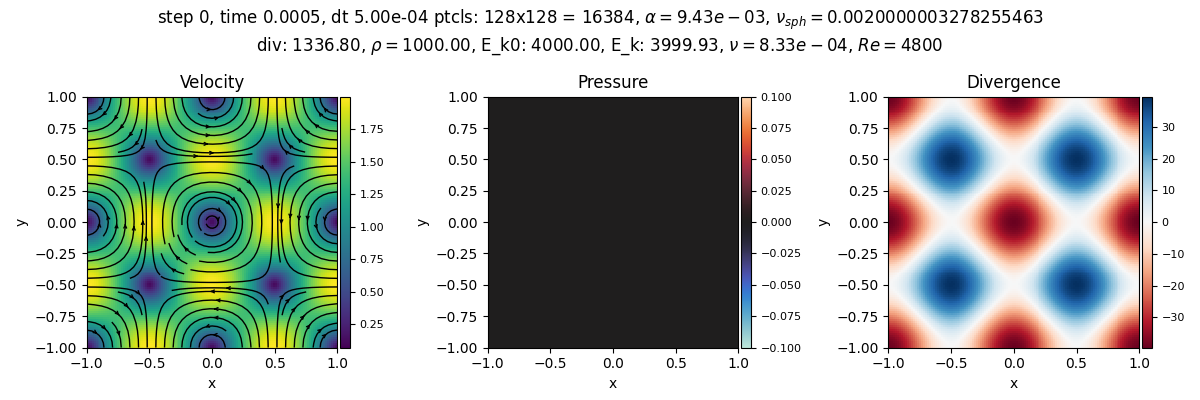

In [9]:
from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity
from diffSPH.v2.plotting import exportPlot, postProcessPlot
fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      'velocities',
                                      mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=True, cmap = 'viridis', title = 'Velocity', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = True)
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'pressures',
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'icefire', streamLines = False, operation = None, title = 'Pressure', plotBoth = False, which = 'fluid', midPoint = 0)

l2Plot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      div,
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = 'Divergence', plotBoth = False, which = 'fluid', midPoint = 0)

E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
Re = u_mag * 2 / nu_total

fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.4g}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]:.2e}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum():.2f}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$, E_k0: {E_k0:.2f}, E_k: {E_k:.2f}, $\\nu = {nu_total:.2e}$, $Re = {Re:.4g}$')

fig.tight_layout()

# simulationState['fluid']['actualArea'] = simulationState['fluid']['masses'] / simulationState['fluid']['densities']
# 



In [10]:
from diffSPH.v2.simulationSchemes.deltaPlus import checkNaN
priorState = None
for i in tqdm(range(4096)):
    if 'shiftAmount' in perennialState['fluid']:
        del perennialState['fluid']['shiftAmount']
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    dx, _ = solveShifting(perennialState, config)
    numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors']
    perennialState['fluid']['shiftAmount'] = dx
    perennialState['fluid']['positions'][numNeighbors > 5] += dx[numNeighbors > 5]
    if config['compute']['checkNaN']:
        checkNaN(perennialState['fluid']['positions'], 'positions')
        checkNaN(perennialState['fluid']['shiftAmount'], 'shiftAmount')
    perennialState['time'] += perennialState['dt']
    perennialState['timestep'] += 1
    # print(f'Incompressible: Iters: {len(perennialState["fluid"]["convergence_density"])}, residual: {perennialState["fluid"]["convergence_density"][-1]:.4e}, Divergence-Free: Iters: {len(perennialState["fluid"]["convergence_divergence"])}, residual: {perennialState["fluid"]["convergence_divergence"][-1]:.4e}')

    if i % 32 == 0:
        searchNeighbors(perennialState, config)
        visualizationState = prepVisualizationState(perennialState, config)
        div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)
        
        # div = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), operation = 'divergence', gradientMode='difference', neighborhood=perennialState['fluid']['neighborhood'])
        updatePlot(indexPlot, visualizationState, 'velocities')
        updatePlot(quantPlot, visualizationState, 'pressures')
        updatePlot(l2Plot, visualizationState, div)
        
        
        E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
        E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
        nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
        Re = u_mag * 2 / nu_total


        fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.4g}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]:.2e}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum():.2f}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$, E_k0: {E_k0:.2f}, E_k: {E_k:.2f}, $\\nu = {nu_total:.2e}$, $Re = {Re:.4g}$')
        # fig.suptitle(f'step {perennialSta qte["timestep"]}, time {perennialState["time"]:.2f}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum()}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$')

        
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        exportPlot(perennialState, config, fig)



  0%|          | 0/4096 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:

import subprocess
import shlex

outFile = config['plot']['namingScheme'] if config['plot']['namingScheme'] != 'timestep' else config["simulation"]["timestamp"]
if config['plot']['namingScheme'] == 'timestep':
    outFolder = f'{config["plot"]["exportPath"]}/{config["simulation"]["timestamp"]}/'
else:
    outFolder = f'{config["plot"]["exportPath"]}/{config["plot"]["namingScheme"]}/'

os.makedirs(outFolder, exist_ok = True)
# print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
command = '/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r ' + str(config['plot']['exportFPS']) + ' ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos[x];[x][1:v]paletteuse" {outFile}.gif'

subprocess.run(shlex.split(command))
subprocess.run(shlex.split(commandB))
subprocess.run(shlex.split(commandC))

[Parsed_palettegen_2 @ 0x567d15ce7f00] Dupped color: FFFDFDFD


CompletedProcess(args=['ffmpeg', '-loglevel', 'warning', '-hide_banner', '-y', '-i', 'output/2024_07_04-13_07_46/output.mp4', '-i', 'output/palette.png', '-filter_complex', 'fps=30,scale=640:-1:flags=lanczos[x];[x][1:v]paletteuse', '2024_07_04-13_07_46.gif'], returncode=0)